In [6]:
from IPython.display import Image

from qiskit.optimization import QuadraticProgram

ModuleNotFoundError: No module named 'qiskit.optimization'

## Introduction/Motivation



## Theory

# 1. Optimization

Coming back to our example from just now, trying to optimize y while controlling x thus we are looking for a function f which generates a solution y as y = f(x). The key assumption of any attempt at optimization is the existence of an optimal solution. Alternatively a solution which is sufficiently optimal, generally called $\hat{y}$. But how do we know how good our solution is? We need to figure out how close it is to the theoretical optimal solution, for this we need a cost function also known as the loss function or simply the loss which we try to minimize

A cost function can take many different shapes which depend on the number of parameters, application etc. a general way of writing it is. The simplest example for a cost function is one dimensional meaning we have a curve of which we find the minimum. A tricky situation is non-convex loss function which can lead to being stuck at a local minimum.

To make the transition to quantum mechanics, we have to find a way to encode the loss function in a quantum mechanical system. Thinking back to any sort of physics problem, we know that the system always takes the path of least resistance, or occupies the state of least energy. We exploit this very principle when we encode our optimization problem into the hamiltonian of a system. This allows us to find the solution to the problem simply as the ground state of our system. A major advantage of this to the classical state is that the likelihood of finding local minima is a lot lower because of a process called quantum annealing.

For Quantum annealing we start the state of the wuantum system in a uniform superposition of all possible states. Then the system evolves following the time-dependent Schrödinger equation, the quantum-mechanical evolution of physical systems as determined by its Hamiltonian. Thus, the amplitudes of all candidate states keep changing, XXX ending up in the ground state: our solution is found.

# 2. QAOA

After talking about the general differences between optimization in a classical and a quantum scenario we will continue the lecture looking at a specific optimization algorithm, namely QAOA which stands for Quantum Approximate Optimization Algorithm meaning we have an algorithm which gives an approximately optimal solution using quantum methods. 

QAOA was designed to solve combinatorial optimization problems. These are the kind of problems which we can express in terms of a particular cost function - a function that esentially tells us how good our solution is. Usually a cost function looks like the following: .... The single constraint is that only linear and quadratic terms are allowed. Solving an optimizational problem means finding a solution which minimizes the cost function. Now how do we minimize this function and how do we take advantage of quantum computing? 

Before we move on with minimazation, lets talk about the Hamiltonians. Hamiltonian is something that governs the behaviour of any quantum system. It also defines the energies, that our system can be in. QAOA is essentially an algorithm that finds the ground state of a given Hamiltonian - that is the state which corresponds to the lowest energy level. 

Now the exciting part is that we can translate any cost function, which follows the constraints described above, into a Hamiltonian. Hence, minimizing the cost function is equivalent to finding the ground state of the Hamiltonian. 

Now how does one find this ground state? To do that we are going to take advantage of a fundamental theorem of quantum physics - the adiabatic thearem - which tells us that if we have a system in its ground state and we transform this system slowly enough, it will remain in its lowest energy state. Our approach will be to take a simple system, for which we know the ground state and transform it into a system, which corresponds to out problem Hamiltonian, while it remains in its ground state. We are going to do it in small steps. Before we can undestand how it is done, we are going to need some mathematical background. 

As we mentioned, Hamiltonian governs the time evolution of quantum system. In particular in the following way: .... Going back to our idea of transforming a quatum system, we can think of the following transformation: ..... This is the point where we take advantage of quantum computing, because we can prepare this transformation in terms of quantum gates. Now constructing a time evolution operator for this transformation is not trivial, because the problem and mixer Hamiltonian don’t commute. Using the trotterization formula we can express the time evolution operator as a product of p consecutive products of exponentiated mixer and problem Hamiltonian. At each step mixer and problem Hamiltonian exponents are supplied with a parameter beta and gamma respectively. And these parameters play the key role because they sort of simulate the adiabatic process that we want to apply to our system. Naturally one would expect betas to decrease and gammas to increase. This reflects the fact that weight of the problem Hamiltonian should increase and the weight of mixer decrease. 

And this is something we can directly implement! In fact exponentiating the mixer Hamiltonian results in applying a rotational X gate to each qubit whereby the rotation is performed at an angle 2 beta. Exponentiation the problem Hamiltonian results in applying a number of rotational Z gates and controlled rotational Z gates to all the qubits. Now these rotations also depend on the coefficients in our QUBO matrix. 

Well, this explains now the layered architecture of QAOA. Let’s look at an example for a simple MAXCUT problem with just one layer that we will see later. At first, we apply H gates to all the qubits to create the ground state of our mixer Hamiltonian. Next follows a row of single rotational Z gates. Next, we have a controlled rotational Z gate between every pair of qubits. Qiskit actually decomposes these gates into two CNOT gates and one rotational X gate which can are available on IBM quantum devices. Finally, we measure our state.

The whole algorithm looks as follows now. At each optimization step we measure the state of our parametrized circuit. The measurement results in a distribution of probabilities. To evaluate the corresponding energy (that is the cost) we scale the energy for each bitstring that we measured with its probability. And take the average finally. A classical optimizer now tries to minimize this energy by updating parameters of our circuit. As we will see later the role of the optimizer becomes quite crucial. After updating the parameters, we again measure our quantum state. And so on until our optimizer lands in an optimal solution.


## Implementation

We'll now start the daunting task of actually implementing the QAOA algorithm in order to understand how it is able to harness quantum effects to speed up the optimization process.

# 1. MaxCut Problem

We will do this by solving a problem from graph theory: the max-cut Problem. The objective of max-cut is to split the set of vertices of a graph into two subsets, such that the sum of the weights of the edges having one endpoint in each of the subsets is maximum. This, of course, sound like gibberish to anyone not inimitely familiar with graph theory but we can illustrate it with a scenario every student here is familiar with: passing paper messages in a classroom. Now, the nodes of the graph represent the students and the weights of the edges represent the number of messages passed between two students. Take the following as an example situation: 



In [ ]:
Image('Images/Classroom.png')

- We have the four students: Anna, Bob, Clara and Diego
- Teacher wants to limit communication among students, students think teachers don't notice passing of messages put precise count over one hours was held
- the optimization problem is such that the teacher wants to split the students into two separate groups which are unable to communicate while minimizing overall communication
- this simple problem the solution is obvious as the teacher should just make two separate rows far enough apart to prevent the passing of notes
- reduces total communication from 17 to 3 notes passed

Moving onto implementation:

Formalizing this graph

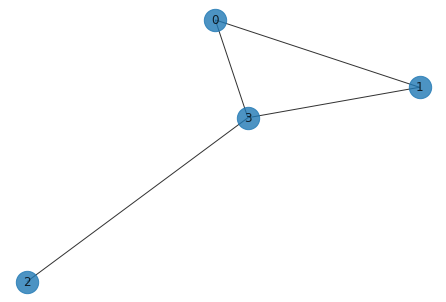

In [3]:
import networkx as nx   # package used for graphing

graph = nx.Graph()  # create the graph

nodes = [0, 1, 2, 3]    # student nodes
edges = [(0,1,2.0), (0,3,4.0), (1,3,10.0), (2,3,1.0)]    # weighted by number of messages between students

# add nodes and edges to graph
graph.add_nodes_from(nodes) 
graph.add_weighted_edges_from(edges)

nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

The next steps of encoding the problem further into a form that the QAOA algorithm can use, namely as QuadraticProgram

In [4]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Generates a QuadraticProblem from a graph.
    Args:
        graph: graph of the problem of class nx.Graph
    Returns: 
        quadratic problem of class QuadraticProgram
    '''
    # get weight matrix from the graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0] # number of nodes
    
    # build QUBO matrix Q from weight matrix
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    
    for i in range(size):
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
            
    # define the quadratic program
    quadratic_program = QuadraticProgram('maxcut')
    
    for i in range(size):
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
        
    quadratic_program.maximize(quadratic=qubo_matrix, linear=qubo_vector, constant=0)
    
    return quadratic_program

NameError: name 'QuadraticProgram' is not defined


## Qiskit



Qiskit is an open-source SDK for working with quantum computers. [documentation](https://qiskit.org)

QAOA has already been implemented by Qiskit which directly extends VQE and inherits VQE’s optimization structure. However, QAOA uses its own fine-tuned ansatz, which comprises parameterized global x rotations and p different parameterizations of the problem hamiltonian.

```python
CLASSQAOA(optimizer=None, reps=1, initial_state=None, mixer=None, initial_point=None, gradient=None, expectation=None, include_custom=False, max_evals_grouped=1, callback=None, quantum_instance=None)
```

#### Important parameters:

__optimizer__: a classical optimizer

__reps__: the integer parameter p

__initial_point__: initial parameter values for the optimizer (optional) may be provided as the starting beta and gamma parameters

Other parameters [here](https://qiskit.org/textbook/ch-applications/qaoa.html)

#### MaxCut Implementation using Qiskit

## Fields of Application


## Additional Resourses @Irene
@TODO: add this to presentation slide for students and remove from here
1. [Documentation on solving otimization problems using Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html)